<font size=5 >Credit Card Approval Prediction Using Sklearn</font>
- Annotated by Adi Singhal and Ethan Assouline

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
!pip install catboost
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# from sklearn import svm
# from sklearn.ensemble import RandomForestClassifier

In [ ]:
data = pd.read_csv("application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("credit_record.csv", encoding = 'utf-8')  

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'

## Feature Engineering

In [ ]:
data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [ ]:
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip   # uncomment this and other pandas profiling commands to generate new reports

In [ ]:
# from pandas_profiling import ProfileReport

In [ ]:
# profile = ProfileReport(data, explorative=True)

In [ ]:
# profile.to_file("pandas_profiling.html")

In [ ]:
# profile2 = ProfileReport(record, explorative=True)

In [ ]:
# profile2.to_file("record_pandas_profiling.html")

### Response Variable

In [ ]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 

new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

In [ ]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,NaN
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,NaN
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,NaN
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,NaN


In [ ]:
record

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [ ]:
record.STATUS.value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

Author's Words : `Generally, users in risk should be in 3%, thus I choose users who overdue for more than 60 days as target risk users. Those samples are marked as '1', else are '0'.`

In [ ]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [ ]:
record

,ID,MONTHS_BALANCE,STATUS,dep_value
0,5001711,0,X,None
1,5001711,-1,0,None
2,5001711,-2,0,None
3,5001711,-3,0,None
4,5001712,0,C,None
...,...,...,...,...
1048570,5150487,-25,C,None
1048571,5150487,-26,C,None
1048572,5150487,-27,C,None
1048573,5150487,-28,C,None


In [ ]:
record.dep_value.value_counts()
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]

In [ ]:
cpunt

,dep_value
ID,
5001711,No
5001712,No
5001713,No
5001714,No
5001715,No
...,...
5150482,No
5150483,No
5150484,No


In [ ]:
new_data=pd.merge(new_data,cpunt,how='inner',on='ID') #only takes rows which have a "record"

new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [ ]:
print(cpunt['dep_value'].value_counts(), "\n")
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64 



No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

We already see that there are only about 1.5% favorable outcomes.

### Features

+ rename 

In [ ]:
new_data.rename(columns={'CODE_GENDER':'Gender',
                         'FLAG_OWN_CAR':'Car',
                         'FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo',
                         'AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp',
                         'NAME_FAMILY_STATUS':'famtp',
                         'NAME_HOUSING_TYPE':'houtp',
                         'FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp',
                         'FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone',
                         'CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [ ]:
new_data # about 36k entries left 

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,No,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,No,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,-9.0,Yes,1


#### Here the ADS is going to drop all null values. Let's see if this has a disproportionate impact on any one group's representation in the data.

In [ ]:
pre_drop = new_data.copy()

In [ ]:
new_data = new_data.mask(new_data == 'NULL').dropna() # drops all null values (which only exist in the occupation column)

In [ ]:
new_data # final df only has 25k entries. 

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,-9.0,Yes,1


In [ ]:
count_null = pd.DataFrame(columns=["Gender", "Occyp_null"])
count_null['Gender'] = pre_drop["Gender"]
count_null['Occyp_null'] = pre_drop.occyp.isnull()
count_null.groupby("Gender").agg(lambda x: sum(x)/len(x))

,Occyp_null
Gender,
F,0.360213
M,0.209778


In [ ]:
sum(pre_drop["Gender"]=='F')/len(pre_drop["Gender"])

0.6701045066791014

In [ ]:
sum(new_data["Gender"]=='F')/len(new_data["Gender"])

0.6218667939842445

We see that while only 21% of Males had missing occupations, that number was 36% for females. When dropping values, we reduced the proportion of females in the dataset from 67% to 62% (although they are still the majority)

In [ ]:
from scipy.stats import entropy
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [ ]:
kl_test(pre_drop, new_data, 'occyp')

0.0

In [ ]:
# did any columns change drastically? 

# testing KS_divergence
from scipy import stats
p_value = 0.01
rejected = {}
for col in range(len(pre_drop.columns)):
  if (pre_drop.columns[col] != "occyp"):
    test = stats.ks_2samp(pre_drop.iloc[:, col], new_data.iloc[:, col])
    if test[1] < p_value:
          rejected[pre_drop.columns[col]] = test[1]

print("We rejected ",len(rejected)," columns in total") 

for each in rejected:
  print(each, ':', round(rejected[each], 5))


We rejected  13  columns in total
ID : 0.00838
Gender : 0.0
Car : 0.0
Reality : 0.00028
ChldNo : 0.0
inc : 0.0
inctp : 0.0
edutp : 0.00748
famtp : 5e-05
DAYS_BIRTH : 0.0
DAYS_EMPLOYED : 0.0
wkphone : 0.0
famsize : 0.0


In [ ]:
# testing KL_divergence
kl_div = pd.DataFrame(columns=['variable', 'KL_divergence'])
for col in pre_drop.columns:
  dct = {
        'variable' : col,
        'KL_divergence' : kl_test(pre_drop, new_data, col)
         }
  kl_div = kl_div.append(dct, ignore_index=True)

In [ ]:
kl_div.sort_values("KL_divergence", inplace=True)
kl_div['KL_divergence'] = kl_div['KL_divergence'].apply(lambda x: round(x, 3))
kl_div.reset_index(drop=True)

,variable,KL_divergence
0,occyp,0.000
1,FLAG_MOBIL,0.000
2,target,0.000
3,dep_value,0.000
4,phone,0.000
5,begin_month,0.000
6,Reality,0.001
7,email,0.001
8,edutp,0.001
9,houtp,0.001


This KL-divergence analysis is very useful. 

We see that occupation has a divergence of 0 before and after the drop because only null values were dropped and thus the distribution of values did not change.
However, we see that Gender had a small change in distribution (we expected to see this from our own analysis of proportions done earlier. 
Additionally, we see that the distribution of birthdates, amount of time worked, and income type have drastically changed. In fact, income has also changed a little. Let's try to plot these changes.

Text(0.5, 0, 'Age (post-drop)')

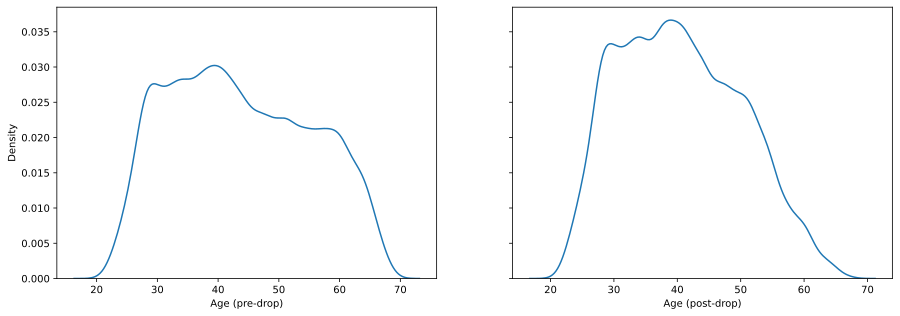

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.kdeplot(abs(pre_drop.DAYS_BIRTH/365), ax=ax[0])
ax[0].set_xlabel('Age (pre-drop)')
sns.kdeplot(abs(new_data.DAYS_BIRTH/365), ax=ax[1])
ax[1].set_xlabel('Age (post-drop)')

It seems as though the dropping significantly made the sample population younger. We can see some density mass being shaved off of the older end of the spectrum.

Text(0.5, 0, 'Years employed (post-drop)')

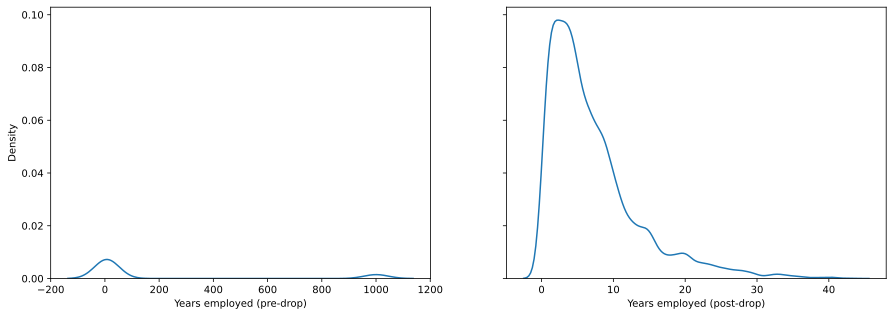

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.kdeplot(abs(pre_drop.DAYS_EMPLOYED/365), ax=ax[0])
ax[0].set_xlabel('Years employed (pre-drop)')
sns.kdeplot(abs(new_data.DAYS_EMPLOYED/365), ax=ax[1])
ax[1].set_xlabel('Years employed (post-drop)')

These are perplexing results. It appears as though the original data pre-drop had an abnormal bimodal distribution with one centering around 0 years of experience and the other around a 1000. There is definitely something wrong with the DAYS_EMPLOYED variable. What if we try to subset the data to only those people who have been employed for less than 800 years?

Text(0.5, 0, 'Years employed (post-drop)')

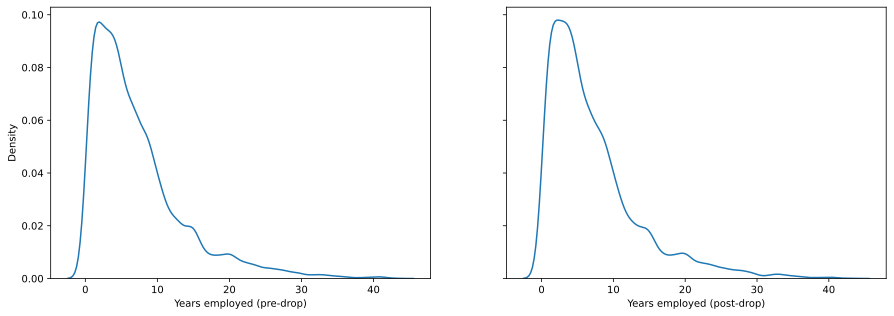

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.kdeplot(abs(pre_drop.DAYS_EMPLOYED[pre_drop.DAYS_EMPLOYED<(800*365)]/365), ax=ax[0])
ax[0].set_xlabel('Years employed (pre-drop)')
sns.kdeplot(abs(new_data.DAYS_EMPLOYED[new_data.DAYS_EMPLOYED<(800*365)]/365), ax=ax[1])
ax[1].set_xlabel('Years employed (post-drop)')

These distributions are much more similar. Turns out, all the differences were being caused by the population with abnormally high working days.

Text(0.5, 0, 'Income in thousands (post-drop)')

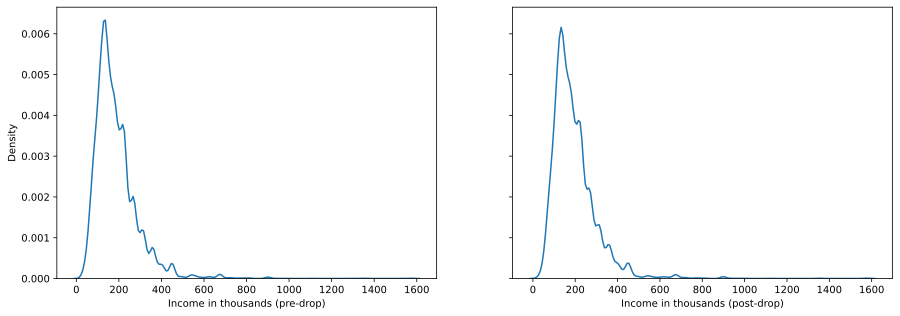

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.kdeplot(pre_drop.inc/1000, ax=ax[0])
ax[0].set_xlabel('Income in thousands (pre-drop)')
sns.kdeplot(new_data.inc/1000, ax=ax[1])
ax[1].set_xlabel('Income in thousands (post-drop)')

In [ ]:
compare = pd.DataFrame()
new_data_inc_list = list(new_data.inctp)
compare['pre_drop'] = list(pre_drop.inctp)
compare['new_data'] = [new_data_inc_list[i] if i<len(new_data_inc_list) else None for i in range(len(list(pre_drop.inctp)))]
compare = compare.melt()

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

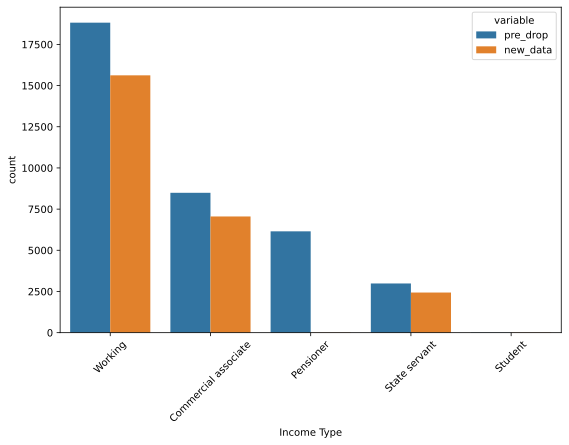

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot("value", hue="variable", data=compare)
plt.xlabel("Income Type")
plt.xticks(rotation=45)

In [ ]:
(len(pre_drop) - len(new_data))/len(pre_drop)

0.3105850728255205

In [ ]:
print("Percentage changes for each type of income")
round((pre_drop.inctp.value_counts() - new_data.inctp.value_counts())/pre_drop.inctp.value_counts(), 3)

Percentage changes for each type of income


Commercial associate    0.169
Pensioner               0.998
State servant           0.184
Student                 0.091
Working                 0.170
Name: inctp, dtype: float64

We see that while the proportion of total values dropped was around 30%, the population with income types of commerical associates, working class and state servants saw a drop of around 17% each. The student population was very small to begin with and so by going from 11 to 10 people, it saw just a 9% drop. Finally, and most interestingly, almost ALL the pensioners were dropped from the sample. They were the most likely to have nothing listed under "occupation." Let's try to manually look at the population who were pensioners and had more than 800 years of DAYS_EMPLOYED. 

In [ ]:
to_inspect = pre_drop[pre_drop.DAYS_EMPLOYED>(800*365)]
# to_inspect = pre_drop[pre_drop.occyp.isnull()]
to_inspect

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,-20.0,No,0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,-16.0,No,0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,-17.0,No,0
69,5008884,F,N,Y,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186,365243,1,0,0,0,NaN,1.0,-40.0,No,0
150,5008974,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22319,365243,1,0,0,0,NaN,2.0,-49.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36408,5126278,F,N,N,0,162000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21244,365243,1,0,0,0,NaN,2.0,-28.0,Yes,1
36418,5139446,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21256,365243,1,0,1,0,NaN,1.0,-16.0,Yes,1
36432,5145690,F,N,Y,0,306000.0,Pensioner,Higher education,Married,House / apartment,-21590,365243,1,0,0,0,NaN,2.0,-17.0,Yes,1
36434,5145817,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22011,365243,1,0,0,0,NaN,2.0,-39.0,Yes,1


We see that the DAYS_EMPLOYED variable uses a filler value of 365342 for all pensioners - this abnormally high value was what was causing the bimodal distribution. So the Author of the ADS completely drops the older, retired population which has no occupation listed and are all pensioners.

We can already see that this absurd population with really high DAYS_EMPLOYED is largely made up of pensioners.

In [ ]:
to_inspect.describe()

,ID,ChldNo,inc,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,famsize,begin_month
count,6.135000e+03,6135.000000,6135.000000,6135.000000,6135.0,6135.0,6135.0,6135.000000,6135.000000,6135.000000,6135.000000
mean,5.074650e+06,0.050204,148590.916137,-21768.196088,365243.0,1.0,0.0,0.288183,0.034882,1.748655,-25.870090
std,4.173749e+04,0.282790,76593.371512,1934.972190,0.0,0.0,0.0,0.452953,0.183495,0.556613,16.774582
min,5.008812e+06,0.000000,29250.000000,-25152.000000,365243.0,1.0,0.0,0.000000,0.000000,1.000000,-60.000000
25%,5.038624e+06,0.000000,94500.000000,-23094.500000,365243.0,1.0,0.0,0.000000,0.000000,1.000000,-40.000000
50%,5.067042e+06,0.000000,135000.000000,-21967.000000,365243.0,1.0,0.0,0.000000,0.000000,2.000000,-24.000000
75%,5.113456e+06,0.000000,180000.000000,-20852.000000,365243.0,1.0,0.0,1.000000,0.000000,2.000000,-11.000000
max,5.150423e+06,3.000000,742500.000000,-8145.000000,365243.0,1.0,0.0,1.000000,1.000000,5.000000,0.000000


Let's change the population to be inspected from all people with high working days to all the people who were dropped.

In [ ]:
# to_inspect = pre_drop[pre_drop.DAYS_EMPLOYED>(800*365)]
to_inspect = pre_drop[pre_drop.occyp.isnull()]
to_inspect

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,No,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,No,0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,-20.0,No,0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,-16.0,No,0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,-17.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36439,5148602,M,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22946,365243,1,0,0,0,NaN,2.0,-15.0,Yes,1
36440,5148679,F,N,N,0,121500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18828,-6195,1,0,0,0,NaN,2.0,-23.0,Yes,1
36445,5149055,F,N,Y,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15837,-2694,1,1,1,0,NaN,2.0,-19.0,Yes,1
36446,5149056,F,N,Y,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15837,-2694,1,1,1,0,NaN,2.0,-42.0,Yes,1


Text(0.5, 0, 'Age (Dropped people)')

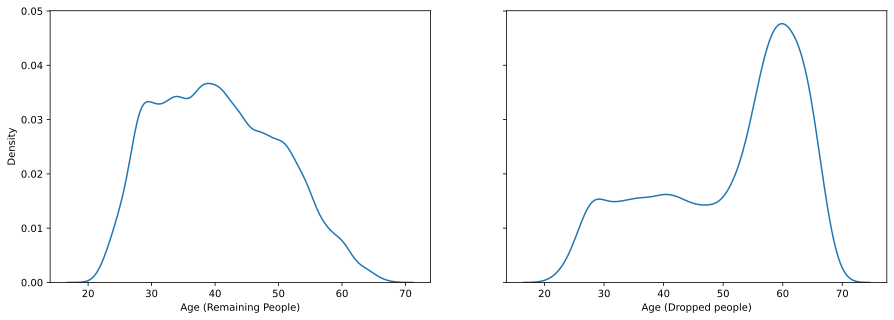

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.kdeplot(abs(new_data.DAYS_BIRTH/365), ax=ax[0])
ax[0].set_xlabel('Age (Remaining People)')
sns.kdeplot(abs(to_inspect.DAYS_BIRTH/365), ax=ax[1])
ax[1].set_xlabel('Age (Dropped people)')

In [ ]:
pre_drop.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'ChldNo', 'inc', 'inctp', 'edutp',
       'famtp', 'houtp', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'wkphone', 'phone', 'email', 'occyp', 'famsize', 'begin_month',
       'dep_value', 'target'],
      dtype='object')

Text(0.5, 0, 'Gender (Group to be inspected)')

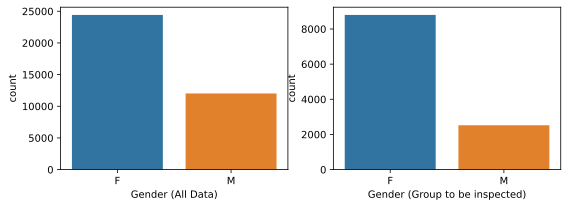

In [ ]:
fig, ax = plt.subplots(1,2, sharey=False, figsize=(9,3))
sns.countplot(pre_drop.Gender, ax=ax[0], order=['F', 'M'])
ax[0].set_xlabel('Gender (All Data)')
sns.countplot(to_inspect.Gender, ax=ax[1], order=['F', 'M'])
ax[1].set_xlabel('Gender (Group to be inspected)')

Text(0.5, 0, 'Car or No Car (Group to be inspected)')

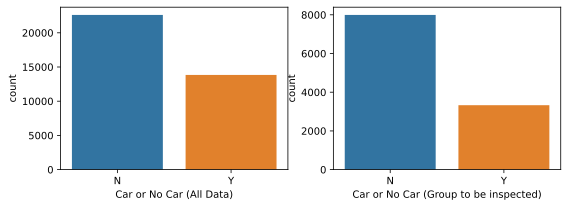

In [ ]:
fig, ax = plt.subplots(1,2, sharey=False, figsize=(9,3))
sns.countplot(pre_drop.Car, ax=ax[0], order=['N', 'Y'])
ax[0].set_xlabel('Car or No Car (All Data)')
sns.countplot(to_inspect.Car, ax=ax[1], order=['N', 'Y'])
ax[1].set_xlabel('Car or No Car (Group to be inspected)')

Text(0.5, 0, 'Target (Group to be inspected)')

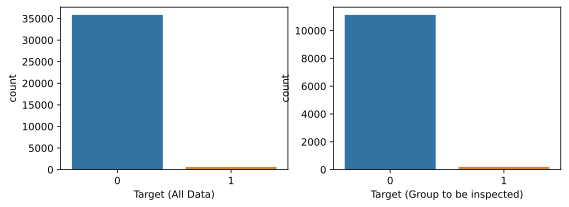

In [ ]:
fig, ax = plt.subplots(1,2, sharey=False, figsize=(9,3))
sns.countplot(pre_drop.target, ax=ax[0])
ax[0].set_xlabel('Target (All Data)')
sns.countplot(to_inspect.target, ax=ax[1])
ax[1].set_xlabel('Target (Group to be inspected)')

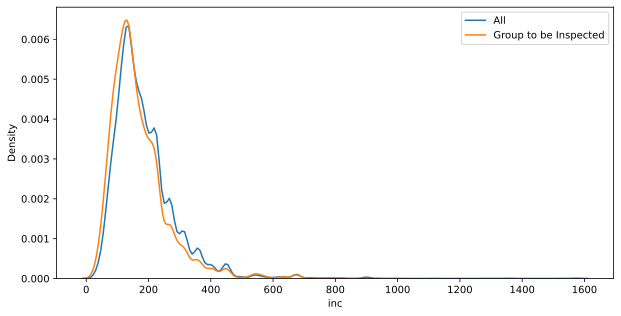

In [ ]:
plt.figure(figsize=(10,5))
sns.kdeplot(pre_drop.inc/1000, label = 'All')
sns.kdeplot(to_inspect.inc/1000, label = 'Group to be Inspected')
plt.legend()

[Text(0, 0, 'Separated'),
 Text(0, 0, 'Single / not married'),
 Text(0, 0, 'Widow'),
 Text(0, 0, 'Civil marriage'),
 Text(0, 0, 'Married')]

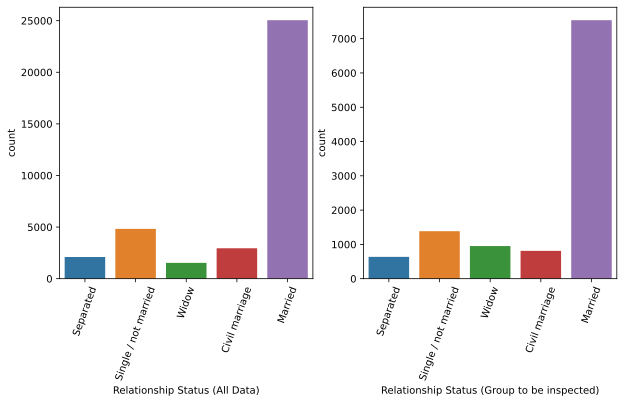

In [ ]:
labels = list(set(pre_drop.famtp))

fig, ax = plt.subplots(1,2, sharey=False, figsize=(10,5))
sns.countplot(pre_drop.famtp, ax=ax[0], order = labels)
ax[0].set_xlabel('Relationship Status (All Data)')
ax[0].set_xticklabels(labels, rotation = 70)
sns.countplot(to_inspect.famtp, ax=ax[1], order = labels)
ax[1].set_xlabel('Relationship Status (Group to be inspected)')
ax[1].set_xticklabels(labels, rotation = 70)

[Text(0, 0, 'Secondary / secondary special'),
 Text(0, 0, 'Incomplete higher'),
 Text(0, 0, 'Lower secondary'),
 Text(0, 0, 'Higher education'),
 Text(0, 0, 'Academic degree')]

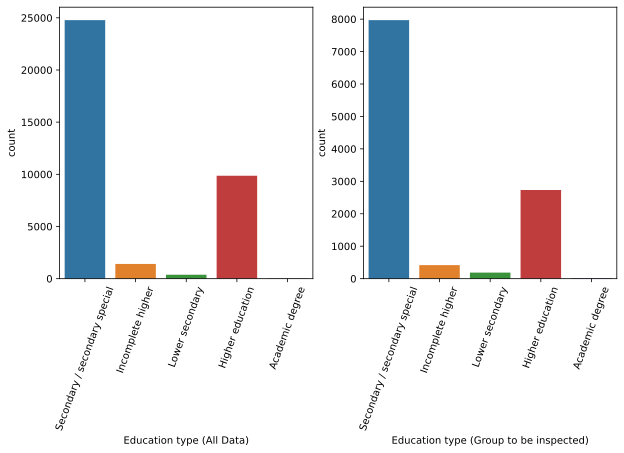

In [ ]:
labels = list(set(pre_drop.edutp))

fig, ax = plt.subplots(1,2, sharey=False, figsize=(10,5))
sns.countplot(pre_drop.edutp, ax=ax[0], order = labels)
ax[0].set_xlabel('Education type (All Data)')
ax[0].set_xticklabels(labels, rotation = 70)
sns.countplot(to_inspect.edutp, ax=ax[1], order = labels)
ax[1].set_xlabel('Education type (Group to be inspected)')
ax[1].set_xticklabels(labels, rotation = 70)

There doesn't seem to be much difference in the general population vs the people who were dropped except that the people who were dropped were much older and usually pensioners. There was barely any difference in Gender distribution or income distribution.

In [ ]:
new_data

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,-9.0,Yes,1


In [ ]:
ivtable = pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV'] = None

In [ ]:
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

In [ ]:
ivtable

,variable,IV
1,Gender,None
2,Car,None
3,Reality,None
4,ChldNo,None
5,inc,None
6,inctp,None
7,edutp,None
8,famtp,None
9,houtp,None
10,DAYS_BIRTH,None


+ Define `calc_iv` function to [calculate](https://www.kaggle.com/puremath86/iv-woe-starter-for-python) Information Value and Weight Of Evidence (WOE) Value

#### Binary Features

In [ ]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [ ]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [ ]:
# segments the rows here 

def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##### Gender

In [ ]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
# print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

This variable's IV is: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


What does it mean for the protected attribute Gender to have an Informative Value of 0.025 in relation to the target variable?

##### Having a car or not

In [ ]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
# print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

This variable's IV is: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


##### Having house reality or not

In [ ]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
# print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

This variable's IV is: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


##### Having a phone or not

In [ ]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

1    0.292791
0    0.707209
Name: phone, dtype: float64
This variable's IV is: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


##### Having an email or not

In [ ]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64
This variable's IV is: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


##### Having a Work Phone or not

In [ ]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

This variable's IV is: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


#### Continuous Variables

##### Children Numbers

In [ ]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


In [ ]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

This variable's IV is: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [ ]:
new_data = convert_dummy(new_data,'ChldNo')

From this analysis it seems as though Gender seems to matter more than how many dependents a person has

##### Annual Income
bins the data based on sample quantiles

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


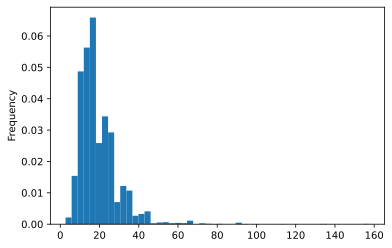

In [ ]:
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [ ]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

This variable's IV is: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_inc, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,gp_inc,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_inc,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


In [ ]:
new_data = convert_dummy(new_data,'gp_inc')

##### Age
Bucketing Continuous Variables

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


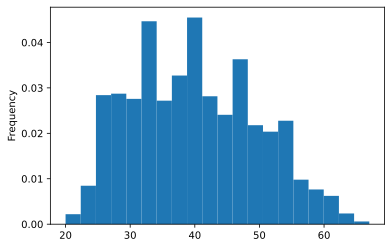

In [ ]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [ ]:
new_data = convert_dummy(new_data,'gp_Age')

##### Working Years
+ Equal-length Bucketing

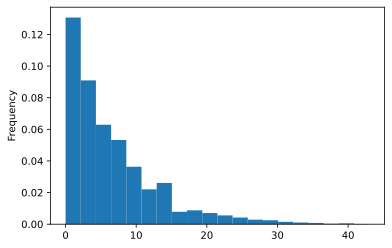

In [ ]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365	
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [ ]:
new_data = convert_dummy(new_data,'gp_worktm')

##### Famliy Size

In [ ]:
new_data['famsize'].value_counts(sort=False)

2.0     12697
1.0      4263
3.0      5216
4.0      2576
6.0        51
9.0         2
5.0       307
7.0        18
20.0        1
15.0        3
Name: famsize, dtype: int64

In [ ]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

This variable's IV is: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [ ]:
new_data = convert_dummy(new_data,'famsizegp')

#### Categorical Features

##### Income Type

In [ ]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

Working                 15622
Student                    10
Commercial associate     7052
State servant            2437
Pensioner                  13
Name: inctp, dtype: int64
Working                 0.621549
Student                 0.000398
Commercial associate    0.280576
State servant           0.096960
Pensioner               0.000517
Name: inctp, dtype: float64
This variable's IV is: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [ ]:
new_data = convert_dummy(new_data,'inctp')

##### Occupation Type

In [ ]:
# classifies the people based on occupation here 

new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
This variable's IV is: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [ ]:
new_data = convert_dummy(new_data,'occyp')

##### House Type

In [ ]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

This variable's IV is: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [ ]:
new_data = convert_dummy(new_data,'houtp')

##### Education

In [ ]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

This variable's IV is: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [ ]:
new_data = convert_dummy(new_data,'edutp')

#####  Marriage Condition

In [ ]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Separated               0.058367
Married                 0.696626
Single / not married    0.137065
Widow                   0.023076
Civil marriage          0.084865
Name: famtp, dtype: float64

In [ ]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

This variable's IV is: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [ ]:
new_data.drop(columns=['FLAG_MOBIL'], inplace=True)

In [ ]:
new_data = convert_dummy(new_data,'famtp')

In [ ]:
# profile3 = ProfileReport(new_data, explorative=True)

In [ ]:
# profile3.to_file("post-processing_data_pandas_profiling.html")

### IV - WOE：Concept and Application

Relationship between IV value and predictive power

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Almost no predictive power | 
|0.02~0.1 |weak predictive power|
|0.1~0.3|Moderate predictive power|
|0.3~0.5|Strong predictive power|
|>0.5|Predictive power is too strong, need to check variables| 

In [ ]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.0659351
8,famtp,0.0431371
11,worktmgp,0.0402215
3,Reality,0.0274407
1,Gender,0.0252035
7,edutp,0.0103618
9,houtp,0.0073275
17,famsize,0.00615614
16,occyp,0.00482047
5,incgp,0.002422


From the authors's analysis, they concludes that Gender is an important predictor of good credit and chance of credit card approval = even more so than education, family size, having a house, income group etc. Age and family type (single, married etc.) seem to have bigger impacts.

## Algorithms

+ Split Dataset

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'wkphone', 'phone', 'email', 'famsize', 'begin_month', 'dep_value',
       'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high', 'gp_inc_medium',
       'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest',
       'worktm', 'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

In [ ]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow']]

In [ ]:
# profile4 = ProfileReport(X, explorative=True)
# profile4.to_file("final_X_table_pandas_profiling.html")

+ Using Synthetic Minority Over-Sampling Technique(`SMOTE`) to overcome sample imbalance problem.

In [ ]:
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_sample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

In [ ]:
X

,Gender,Reality,ChldNo_1,ChldNo_2More,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,occyp_hightecwk,occyp_officewk,famsizegp_1,famsizegp_3more,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
2,1.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,1.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36453,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
36454,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
36455,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.describe()

,Gender,Reality,ChldNo_1,ChldNo_2More,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,occyp_hightecwk,occyp_officewk,famsizegp_1,famsizegp_3more,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
count,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000
mean,0.378133,0.654930,0.243415,0.123657,0.175619,0.039508,0.310575,0.159346,0.016909,0.003581,0.198416,0.054826,0.177250,0.405148,0.169611,0.325217,0.006048,0.032307,0.007918,0.017466,0.056895,0.284316,0.039508,0.007440,0.084865,0.058367,0.137065,0.023076
std,0.484931,0.475401,0.429152,0.329197,0.380503,0.194805,0.462738,0.366006,0.128934,0.059734,0.398815,0.227645,0.381888,0.490931,0.375298,0.468465,0.077532,0.176817,0.088629,0.131004,0.231647,0.451097,0.194805,0.085936,0.278686,0.234441,0.343923,0.150149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_balance.describe()

,Gender,Reality,ChldNo_1,ChldNo_2More,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,occyp_hightecwk,occyp_officewk,famsizegp_1,famsizegp_3more,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
count,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.000000,49424.00000
mean,0.414243,0.616506,0.232222,0.123006,0.274516,0.194195,0.023426,0.295638,0.177977,0.009749,0.001821,0.167474,0.040878,0.177089,0.382947,0.180644,0.316843,0.005903,0.034440,0.007677,0.013059,0.054078,0.287556,0.042801,0.008126,0.071430,0.044201,0.159605,0.02838
std,0.489493,0.474713,0.418339,0.325943,0.435695,0.389587,0.147835,0.449676,0.375665,0.096240,0.042634,0.362630,0.191625,0.372733,0.478626,0.381786,0.461695,0.071076,0.173304,0.081983,0.107739,0.218271,0.444294,0.198509,0.082150,0.247699,0.201505,0.358053,0.16415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,1.000000,0.000000,0.000000,0.934849,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


SMOTE balancing works to an extent when it comes to gender because he is able to reduce the women majority from a 62% to 59%.

In [ ]:
Y.describe()

count    25134.000000
mean         0.016790
std          0.128486
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64

In [ ]:
pd.Series(Y_balance).describe()

count    49424.000000
mean         0.500000
std          0.500005
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
dtype: float64

SMOTE balancing also makes sure that there are equal number of exampels for the binary target variable.

+ After over sampling, the number between 1 and 0 is balanced. It can be seen from the confusion matrix.

In [ ]:
#random state = 10086

# X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
#                                                     stratify=Y_balance, test_size=0.3,
#                                                     random_state = 10086)

# Our random state = 42

# X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
#                                                     stratify=Y_balance, test_size=0.3,
#                                                     random_state = 42)

import joblib

# joblib.dump(X_train, "/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_X_train_seed42.joblib")
# joblib.dump(X_test, "/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_X_test_seed42.joblib")
# joblib.dump(y_train, "/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_y_train_seed42.joblib")
# joblib.dump(y_test, "/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_y_test_seed42.joblib")

X_train = joblib.load("/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_X_train_seed42.joblib")
X_test = joblib.load("/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_X_test_seed42.joblib")
y_train = joblib.load("/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_y_train_seed42.joblib")
y_test = joblib.load("/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_y_test_seed42.joblib")

### CatBoost

In [ ]:
# takes about 45 mins to run, so just load the saved model from the drive instead

# model = CatBoostClassifier(iterations=250,
#                            learning_rate=0.2,
#                            od_type='Iter',
#                            verbose=25,
#                            depth=16,
#                            random_seed=42)

# model.fit(X_train, y_train)

# import joblib
# joblib.dump(model, "/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_model04052021.joblib")

In [ ]:
import joblib
model = joblib.load("/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/saved_model04052021.joblib")

In [ ]:
y_predict = model.predict(X_test)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

CatBoost Accuracy Score is 0.94976
      0     1
0  6868   546
1   199  7215


#### Analysing the results of this 95% accurate Neural Network

In [ ]:
y_predict

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
X_test

,Gender,Reality,ChldNo_1,ChldNo_2More,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,occyp_hightecwk,occyp_officewk,famsizegp_1,famsizegp_3more,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
17029,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
14059,1.0,0.000000,1.0,0.0,1.000000,0.0,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.00000
16776,1.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
42802,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.062436,0.00000
26259,1.0,1.000000,0.0,0.0,0.343290,0.0,0.0,1.00000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31780,1.0,0.580492,0.0,0.0,0.419508,0.0,0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.00000
19628,1.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
31849,1.0,1.000000,0.0,0.0,0.605789,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
35373,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.31518,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.315180,0.68482


In [ ]:
inspect_preds = X_test.copy()
inspect_preds['y_true'] = y_test
inspect_preds['y_pred'] = y_predict
# inspect_preds.to_csv("results_catboost_to_inspect.csv")
inspect_preds.head()

,Gender,Reality,ChldNo_1,ChldNo_2More,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,occyp_hightecwk,occyp_officewk,famsizegp_1,famsizegp_3more,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow,y_true,y_pred
17029,0.0,0.0,0.0,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0,0
14059,1.0,0.0,1.0,0.0,1.00000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0,0
16776,1.0,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0,0
42802,0.0,1.0,0.0,0.0,1.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.062436,0.0,1,1
26259,1.0,1.0,0.0,0.0,0.34329,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,1


In [ ]:
!pip install aif360
!pip install fairlearn

from aif360.metrics import BinaryLabelDatasetMetric, DatasetMetric
from aif360.datasets import BinaryLabelDataset, StructuredDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer
import json
from collections import OrderedDict

In [ ]:
df_aif = BinaryLabelDataset(df=inspect_preds, label_names=["y_pred"], protected_attribute_names=["Gender"], favorable_label=1, unfavorable_label=0)

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(
     df_aif, 
     unprivileged_groups=[{'Gender':1}],
     privileged_groups=[{'Gender':0}]
  )
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.084530


In [ ]:
print("Original training dataset")
print("Disparate Impact = %f" % metric_orig_train.disparate_impact())

Original training dataset
Disparate Impact = 1.175926


In [ ]:
json_expl = MetricJSONExplainer(metric_orig_train)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

In [ ]:
print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): 0.08452950893192873",
  "numPositivesUnprivileged": 3385.0,
  "numInstancesUnprivileged": 5991.0,
  "numPositivesPrivileged": 4124.0,
  "numInstancesPrivileged": 8583.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


In [ ]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.1759255031917422",
  "numPositivePredictionsUnprivileged": 3385.0,
  "numUnprivileged": 5991.0,
  "numPositivePredictionsPrivileged": 4124.0,
  "numPrivileged": 8583.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


In [ ]:
import shap
shap.initjs()
# explainer = shap.TreeExplainer(model)

# the following explainers take a long time to run, so just load the saved pickles instead. If you don't have access to these files, reach out to me at adis@nyu.edu 
# and I can give it to you. Then please change the path to reflect the real location of the files for your drive. 

# shap_values = explainer.shap_values(X_train)
# joblib.dump(shap_values, "/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/shap_values.joblib")

# test_shap_values = explainer.shap_values(X_test)
# joblib.dump(test_shap_values, "/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/test_shap_values.joblib")

shap_values = joblib.load("/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/shap_values.joblib")
test_shap_values = joblib.load("/content/drive/MyDrive/NYU stuff/Classes/Spring 2021 (Sem 6)/Responsible Data Science (RDS)/RDS Project/catboost_model/test_shap_values.joblib")

# visualize the first prediction's explanation
# shap.summary_plot(shap_values, X_train)

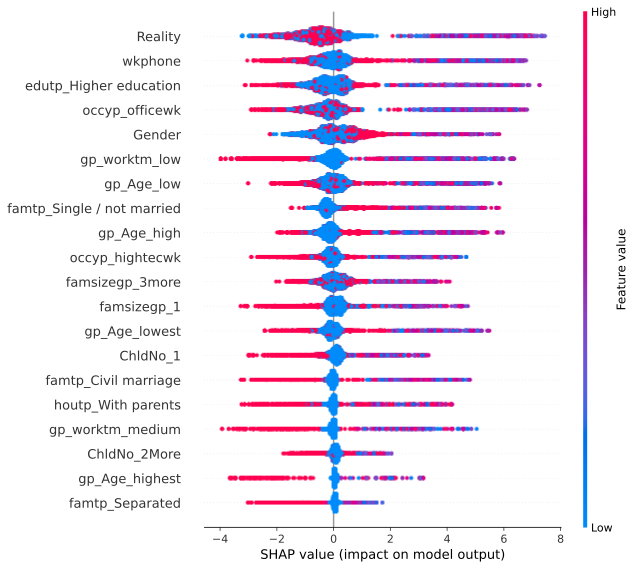

In [ ]:
shap.summary_plot(test_shap_values, X_test)

In [ ]:
# this takes too much RAM

# shap.force_plot(explainer.expected_value, test_shap_values, X_test) 

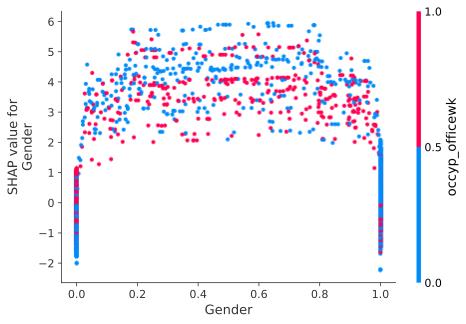

In [ ]:
shap.dependence_plot("Gender", shap_values, X_train)